In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from scipy.interpolate import interp1d

ModuleNotFoundError: No module named 'camb'

In [2]:
#genero spettro potenza
omegab=0.05
omegac=0.25
h=0.7
As=2.1e-9
ns = 0.96

In [3]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=100*h,ombh2=omegab*h**2,omch2=omegac*h**2)
pars.InitPower.set_params(As=As,ns=ns)
pars.set_matter_power(redshifts=[10], kmax=10)

#Linear spectra
#pars.NonLinear = none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints =512)
s8 = np.array(results.get_sigma8())

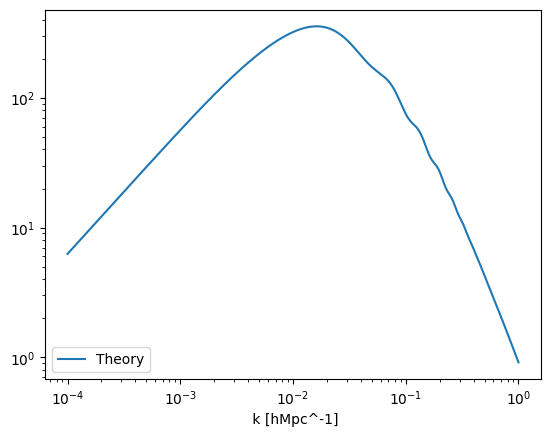

In [4]:
plt.loglog(kh,pk[0])
#plt.legend(loc = "best")
plt.xlabel(' k [h^3Mpc^-1]');
plt.xlabel(' k [hMpc^-1]')
plt.legend(['Theory'], loc='lower left');

In [5]:
pk_int = interp1d(kh,pk[0],kind='cubic',fill_value='extrapolate')

create the grid

In [6]:
#volume 3d
side = 500 #Mpc
Volume = side**3

n_cells=100 #100**3 cells in the cube
spacing =side/n_cells
print('la risoluzione è ',spacing)

la risoluzione è  5.0


In [7]:
kf=2*np.pi/side #h/Mpc
kn = 2*np.pi/spacing
print('fundamental freq ', kf, '[h/Mpc]')
print(kn)

fundamental freq  0.012566370614359173 [h/Mpc]
1.2566370614359172


In [8]:
kx = np.fft.fftfreq(n_cells,spacing)*np.pi*2
ky = np.fft.fftfreq(n_cells,spacing)*np.pi*2
kz = np.fft.rfftfreq(n_cells,spacing)*np.pi*2

print(kx.shape,ky.shape,kz.shape)
#so che la funzione è reale per cui posso usare le tf con quelle caratteristiche

(100,) (100,) (51,)


In [9]:
#kxe ky non sono crescente(prima positivi crescenti poi i negativi crescenti)
kx = np.fft.fftshift(kx) #metto in ordine crescente
ky = np.fft.fftshift(ky)
#kz è solo positivo ed è già ordinato bene

# generate gaussian random field in fourier space

In [10]:
pks = np.zeros((n_cells,n_cells,n_cells//2+1))

#rifaccio quello che fa fftfreq
for i in range(n_cells):
    kx = i if i<=n_cells//2 else i-n_cells
    kx *= 2*np.pi/side
    for j in range(n_cells):
        ky = j if j<=n_cells//2 else j-n_cells
        ky *= 2*np.pi/side
        for k in range(n_cells//2+1):
            kz = k*2*np.pi/side
            knorm = np.sqrt(kx**2+ky**2+kz**2)

            pks[i,j,k] = pk_int(knorm)

In [11]:
# per ogni punto griglia dobbiamo generare una fase e un numero random dalla distribuzione 

In [12]:
phase = np.random.uniform(size=pks.shape)*2*np.pi #grande come griglia
print(phase.shape)

(100, 100, 51)


In [13]:
delta_k_norm = np.random.normal(size=pks.shape)*np.sqrt(pks*Volume) #genero un numero da distribuz gaussiana con media zero e dev1
#la normalizzo per un numero perchè voglio che la dev stndard sia P(k) e non 1
delta_k = delta_k_norm *(np.cos(phase) + 1j*np.sin(phase))

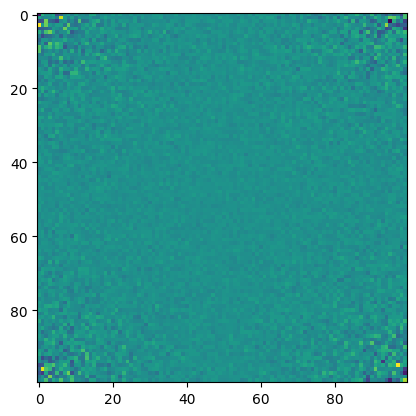

In [14]:
plt.imshow(delta_k_norm[:,:,2])

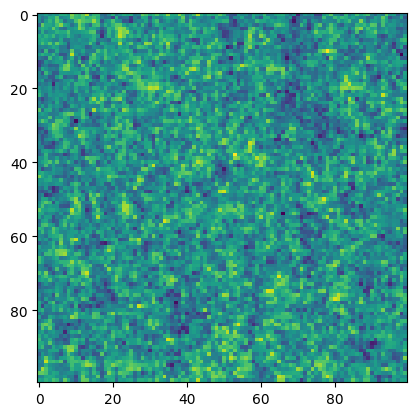

In [15]:
delta_x = np.fft.irfftn(delta_k,norm="backward")/spacing**3
plt.imshow(delta_x[:,:,2])

(array([7.35656287e-05, 0.00000000e+00, 7.35656287e-05, 1.47131257e-04,
        1.47131257e-04, 1.47131257e-04, 2.94262515e-04, 1.25061569e-03,
        1.32418132e-03, 1.32418132e-03, 2.79549389e-03, 3.89897832e-03,
        5.81168467e-03, 7.65082539e-03, 1.23590256e-02, 1.41246007e-02,
        1.90534978e-02, 2.74399795e-02, 3.96518739e-02, 5.06867182e-02,
        7.12115286e-02, 9.03385921e-02, 1.18146400e-01, 1.48749701e-01,
        1.97229451e-01, 2.34380093e-01, 3.02060472e-01, 3.59000268e-01,
        4.57136817e-01, 5.49240984e-01, 6.53409914e-01, 7.63096267e-01,
        9.08756212e-01, 1.04146861e+00, 1.21537775e+00, 1.37538299e+00,
        1.55179337e+00, 1.75843922e+00, 1.90946946e+00, 2.07822901e+00,
        2.24750352e+00, 2.40434544e+00, 2.57737180e+00, 2.67337495e+00,
        2.76040309e+00, 2.86942735e+00, 2.90466528e+00, 2.96035447e+00,
        2.94586204e+00, 2.89841221e+00, 2.81646010e+00, 2.75738690e+00,
        2.64542001e+00, 2.51130987e+00, 2.35741057e+00, 2.206748

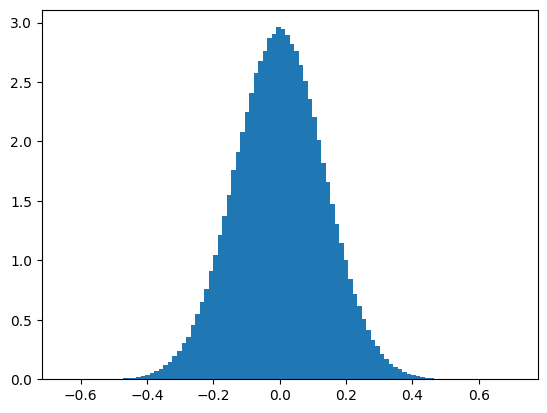

In [16]:
plt.hist(delta_x.flatten(),bins=100,density=True)
#per costruzione non può essere minore di -1

# Extract power spectrum

In [17]:
kx = np.fft.fftfreq(n_cells,spacing)*np.pi*2
ky = np.fft.fftfreq(n_cells,spacing)*np.pi*2
kz = np.fft.rfftfreq(n_cells,spacing)*np.pi*2

In [18]:
kk = np.sqrt(kx**2+ky**2+kz**2)

ValueError: operands could not be broadcast together with shapes (100,) (51,) 

In [19]:
knorm=[]
for i in range(n_cells):
    kx = i if i<=n_cells//2 else i-n_cells
    kx *= 2*np.pi/side
    for j in range(n_cells):
        ky = j if j<=n_cells//2 else j-n_cells
        ky *= 2*np.pi/side
        for k in range(n_cells//2+1):
            kz = k*2*np.pi/side
            knorm.append(np.sqrt(kx**2+ky**2+kz**2))

            #pks[i,j,k] = pk_int(knorm)

In [20]:
delta_k_sq=np.abs(delta_k)**2
pks=delta_k_sq.flatten()/Volume

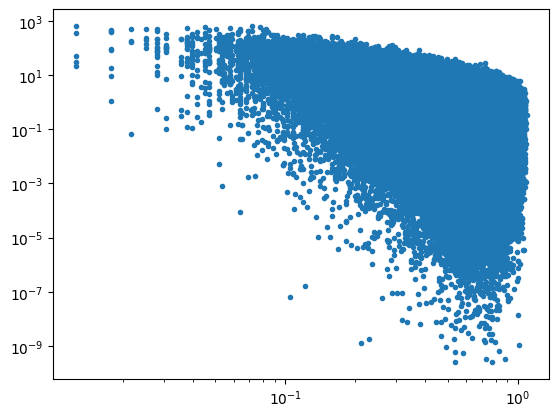

In [21]:
plt.loglog(knorm,pks,".")

In [22]:
edges = np.arange(kf,kn,kf)

In [23]:
pk_meas = np.zeros(len(edges)-1)
k_bin = (edges[1:]+edges[0:-1])/2

In [24]:
for i in range(len(k_bin)):
    k_selec = np.where((knorm>edges[i]) & (knorm<edges[i+1]))[0]
    pk_meas[i] = np.mean(pks[k_selec])

/home/elisalentini/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elisalentini/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


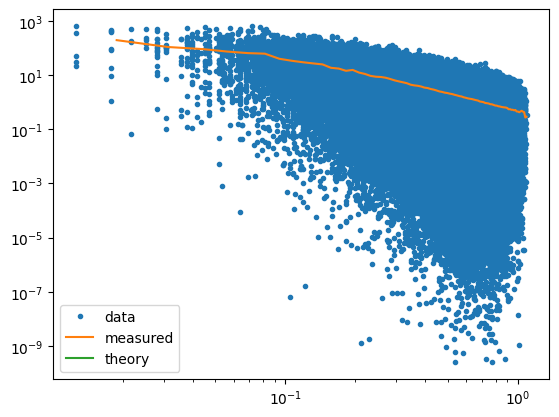

In [25]:
plt.loglog(knorm,pks,".",label="data")
plt.loglog(k_bin,pk_meas,label="measured")
plt.loglog(kh[(kh>kf) & (kh>kn)],pk[0][(kh>kf) & (kh>kn)],label= "theory")
plt.legend()

In [26]:
#guarda lista che hai fotografato, lezione 13/05 c'è la registrazione

In [28]:
knorm = np.reshape(knorm,newshape=(100,100,51))

nuovo eser

In [32]:
#power spectrum on the grid
pks=pk_int(knorm)
print(pks.shape)

(100, 100, 51)


In [36]:
#get 2PCF on the grid
xi = np.fft.irfftn(pks)/spacing**3    #tf inversa
#Torno indietro alla funzione correlazione nello spazio delle configurazioni
print(xi.shape)

(100, 100, 100)


In [37]:
xi[1,1,1]

0.006266118777964205

In [41]:
#devo generare un campo con nuova psi

#generate gaussian 2PCF
xi_g = np.log(1+xi)

In [45]:
#get power spectrum for G
pk_g = np.fft.rfftn(xi_g)*spacing**3
print(pk_g.shape)

(100, 100, 51)


In [46]:
#generate G(k)
phase = np.random.uniform(size=pks.shape)*2*np.pi

G_k_norm = np.random.normal(size=pks.shape)*np.sqrt(pk_g*Volume)
G_k_norm[0,0,0]=0
G_k = G_k_norm*(np.cos(phase)+1j*np.sin(phase))

In [54]:
#compute G(k)
G_x = np.fft.irfftn(G_k,norm="backward")/spacing**3

(array([8.0000e+00, 1.0000e+01, 2.1000e+01, 3.4000e+01, 5.8000e+01,
        1.3400e+02, 2.2300e+02, 4.3100e+02, 7.5100e+02, 1.2420e+03,
        2.0930e+03, 3.2500e+03, 5.2220e+03, 7.6190e+03, 1.1162e+04,
        1.5494e+04, 2.0700e+04, 2.6981e+04, 3.4809e+04, 4.2029e+04,
        5.0334e+04, 5.7267e+04, 6.3909e+04, 6.8523e+04, 7.1842e+04,
        7.2284e+04, 6.9714e+04, 6.6429e+04, 6.0750e+04, 5.3589e+04,
        4.5399e+04, 3.8168e+04, 3.0426e+04, 2.3583e+04, 1.7478e+04,
        1.2649e+04, 9.1340e+03, 6.1040e+03, 3.9490e+03, 2.5750e+03,
        1.4810e+03, 9.5500e+02, 5.6200e+02, 2.9300e+02, 1.6500e+02,
        8.4000e+01, 5.4000e+01, 1.8000e+01, 7.0000e+00, 4.0000e+00]),
 array([-0.87218348, -0.83759657, -0.80300966, -0.76842274, -0.73383583,
        -0.69924891, -0.664662  , -0.63007509, -0.59548817, -0.56090126,
        -0.52631434, -0.49172743, -0.45714052, -0.4225536 , -0.38796669,
        -0.35337977, -0.31879286, -0.28420595, -0.24961903, -0.21503212,
        -0.1804452 , -0.14

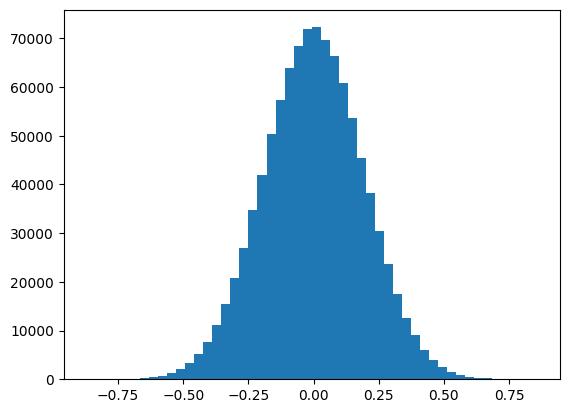

In [55]:
plt.hist(G_x.flatten(),histtype="bar", bins=50)
         

In [56]:
#apply lognormal transorfmation to compute deltax
var_g = np.var(G_x)

In [57]:
delta_x = np.exp(G_x-var_g)-1

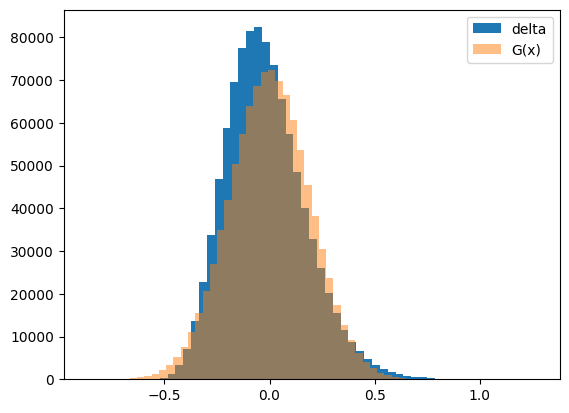

In [61]:
plt.hist(delta_x.flatten(),histtype="bar", bins=50, label="delta")
plt.hist(G_x.flatten(),histtype="bar",alpha=0.5, bins=50,label="G(x)")
plt.legend()

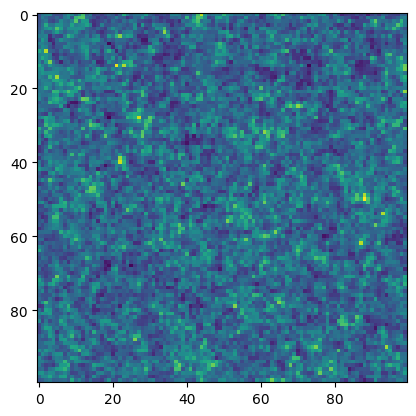

In [63]:
plt.imshow(delta_x[:,:,2])